# Learner

Contains the `Learner` class, the callback functionality and relevant utility functions.

Every part of `Learner` will modifiable via callbacks.

In [ ]:
#| default_exp learner

In [ ]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

from miniai.datasets import *
from miniai.plotting import *
from miniai.utils import *

from fastprogress import progress_bar,master_bar

/home/miniai_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

`Callback` is the superclass of all callbacks. A lower `order` results in earlier execution.

In [ ]:
#|export
class Callback(): order = 0

`run_cbs` runs a given method for all callbacks `cbs`. E.g., if `cbs=[cb1, cb2]` and `method_nm="after_fit"` it runs `cb1.after_fit` and `cb2.after_fit`.

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [ ]:
#|hide
class DummyLearner():
    def __init__(self, name): self.name,self.greetings = name, []

class DummyCallback(Callback):
    def __init__(self, greeting): self.greeting = greeting
    def greet(self, learn): learn.greetings.append(self.greeting + ' ' + learn.name)

john, umer = DummyLearner('John'), DummyLearner('Umer')
cb_hi, cb_hello = DummyCallback('Hi'), DummyCallback('Hello')

cb_hi_low_priority = DummyCallback('Hi')
cb_hi_low_priority.order = 1

run_cbs([cb_hi, cb_hello], 'greet', john)
run_cbs([cb_hi_low_priority, cb_hello], 'greet', umer)

assert john.greetings == ['Hi John', 'Hello John']
assert umer.greetings == ['Hello Umer', 'Hi Umer']

In [ ]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

`MetricsCB` records all metrics and the loss.

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = str(learn.epoch)
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

`DeviceCB` puts the model and each batch onto the specified device.

In [ ]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

`TrainCB` is the default implementation for `predict`, `get_loss`, `backward`, `step` and `zero_grad`

In [ ]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

`ProgressCB` display the metrics recorded via `MetricsCB` as table and optionally as graph. Requires `MetricsCB`.

In [ ]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

`with_cbs(nm)` is a decorator that first run `before_nm`, then the function it wraps and then `after_nm`

Notes on the with_cbs class below.

When used as a decorator the class is instantiated when the Learner class is instantiated with a call to init.

The instantiation also generates a call to the __call__ method which takes the relevant function as f (ie \_one_batch), and return the \_f function.  The \_f function will then be executed whenever the original f function is called

When \_f is executed o will be the learner (ie self). The fact that this is done during initialisation means that when the function is called subequently it actually points to \_f and goes straight to that.

In [ ]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [ ]:
#|hide
class DummyLearner():
    def __init__(self, cbs=None): self.cbs,self.notes = cbs,[]
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @with_cbs('call')
    def call(self): self.notes.append('during call')

    @with_cbs('call')
    def call2(self): self.notes.append('during call2')

class DummyCallback(Callback):
    def before_call(self, learn): learn.notes.append('before call')
    def after_call(self, learn): learn.notes.append('after call')


dummy_learner = DummyLearner([DummyCallback()])
dummy_learner.call()
assert dummy_learner.notes == ['before call', 'during call', 'after call']

dummy_learner = DummyLearner([DummyCallback()])
dummy_learner.call2()
assert dummy_learner.notes == ['before call', 'during call2', 'after call']

In [ ]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
from datasets import load_dataset
import torchvision.transforms.functional as TF
from torch import nn,tensor

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]     

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)

m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

learn = Learner(model, dls, cbs=[TrainCB(), DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)], loss_func=F.cross_entropy)

accuracy,loss,epoch,train
0.620,1.338,0,train
0.661,0.908,0,eval
0.717,0.792,1,train
0.740,0.734,1,eval
0.759,0.689,2,train
0.783,0.651,2,eval
0.784,0.624,3,train
0.785,0.611,3,eval
0.795,0.593,4,train
0.804,0.578,4,eval


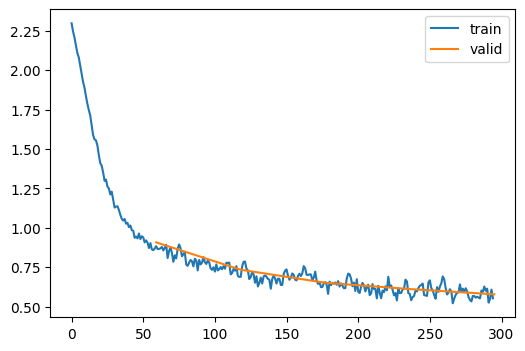

In [ ]:
learn.fit(n_epochs=5)

`TrainLearner` is a `Learner` with `predict`, `get_loss`, `backward`, `step` and `zero_grad` already implemented. This is the same as a plain `Learner` with a `TrainCB`.

In [ ]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

`MomentumLearner` is a `TrainLearner` using `Momentum` instead of vanilla SGD.

In [ ]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [ ]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

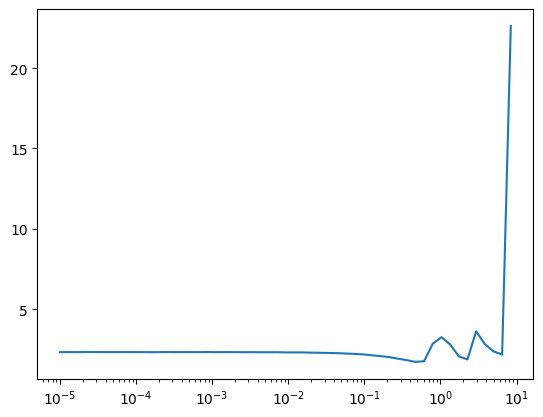

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

learn = TrainLearner(model, dls, loss_func=F.cross_entropy)
learn.lr_find()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()